## Comb Filters

This notebook applies some fundamental DSP concepts to design a comb filter, which we will see is a building block for more complex audio FX such as reverberation. We'll also see how the same structure can be used for modelling the sound of strings.

Written by: Randall Ali - r.ali@surrey.ac.uk
Please feel free to write me if you have any comments/questions about this notebook or if you spot any errors!


In [1]:
# Firstly, let's import some packages:

import numpy as np 
import scipy as sp
from scipy import signal
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt
from  matplotlib import patches
from matplotlib.ticker import FormatStrFormatter
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image, Video
from matplotlib.animation import FuncAnimation
import mpl_toolkits.axes_grid1
import matplotlib.widgets
%matplotlib ipympl
 

### Feedforward Comb Filter.

In Python, linear filters are expressed as a rational transfer function in the following form (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html):

\begin{equation}
H(z) = \frac{b[0] + b[1]z^{-1} + b[2]z^{-2} + \dots + b[M]z^{-M}}{1 + a[1]z^{-1} + a[2]z^{-2} + \dots + a[N]z^{-N}}
\end{equation}

Let's then build the feed forward comb filter depicted in Fig. 1, where N is the length of the delay in samples, and g is a scalar gain. The transfer function of the filter is given by:

\begin{equation}
H(z) = 1 + g z^{-N}
\end{equation}

for which we can recognize as a Finite Impulse Response (FIR) filter as there is no denominator term (i.e., $a[1] =a[2] =... a[N] = 0$ if we compare it to the rational transfer function form above).

So for instance, if N = 2, we will have:
\begin{equation}
H(z) = 1 + g z^{-2}
\end{equation}

where upon comparison to the rational transfer function form, we can see that $b[0] = 1$, $b[1]=0$, and $b[2]=g$.


        
<br>
<br>

<div>
<center> <img src="img/feedfwd_comb.png" width="600"/> <center/>
    <p style="text-align:center">Fig. 1 - A feed forward comb filter. </p>
</div>

<br>
<br>

Output()

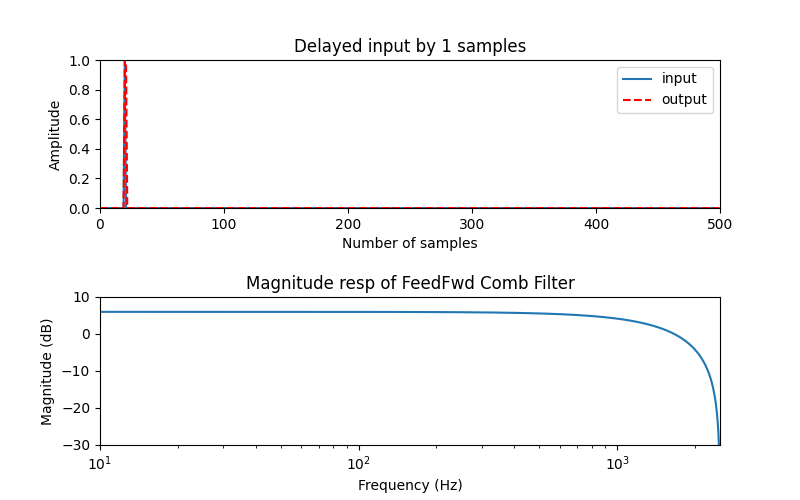

In [2]:
# Building a basic feed forward comb filter line

# Initial parameters
fs = 5000                     # sampling frequency (Hz)
N_samples = 500             # total number of samples
n = np.arange(0,N_samples,1)  # This sets up a vector of the sample indices
x = np.zeros(N_samples);      # initial input
x[20] = 1                    # This makes x an impulse


fig, axes = plt.subplots(2,1, figsize=(8, 5)) 
fig.subplots_adjust(hspace=0.6)
line_input = axes[0].plot(n,x, label='input')
line_output, = axes[0].plot([],[],'r--', label='output')
axes[0].set_xlabel('Number of samples')
axes[0].set_ylabel('Amplitude')
axes[0].set_ylim([0, 1])
axes[0].set_xlim([0, N_samples])
axes[0].legend()

line_mag, = axes[1].semilogx([],[])
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude (dB)')
axes[1].set_title('Magnitude resp of FeedFwd Comb Filter')
axes[1].set_xlim([10, fs//2])
axes[1].set_ylim([-30, 10])




def update(N = 10, g=0.1):
    
    # Create filter
    b = np.zeros(N+1)
    b[0] = 1    # first value of b
    b[-1] = g   # make the last value g (the final coefficient)
    a = 1       # this is the denominator
    
    # Run the filter to get the impulse response
    y_filt = signal.lfilter(b,a,x)  
    line_output.set_data(n, y_filt)
    axes[0].set_title('Delayed input by '+str(N)+' samples')
    
    # Get freq. response of the loop filter    
    [w,h] = signal.freqz(b,a, fs=fs,worN=fs)
    h_abs_dB = 10*np.log10(np.abs(h)**2) # express magnitude in dB
    line_mag.set_data(w,h_abs_dB)
    
    print('Listen to output')
    IPython.display.display(Audio(y_filt.T, rate=fs,normalize=True))
    
    return 

N_s    = IntSlider(min=1, max=400, step=1, value=0, description='N')
g_s    = FloatSlider(min=0, max=0.99, step=0.01, value=1, description='g')

out = interactive_output(update, {'N': N_s, 'g': g_s} ); 
layout = widgets.VBox([N_s, g_s])
IPython.display.display(layout,out)

# y_out = update(N=N_s.value, g = g_s.value)



Listen to the input:


Move the slider to see how the hyperparameters affect performance 


interactive(children=(IntSlider(value=10, description='N', max=4000), FloatSlider(value=0.1, description='g', …

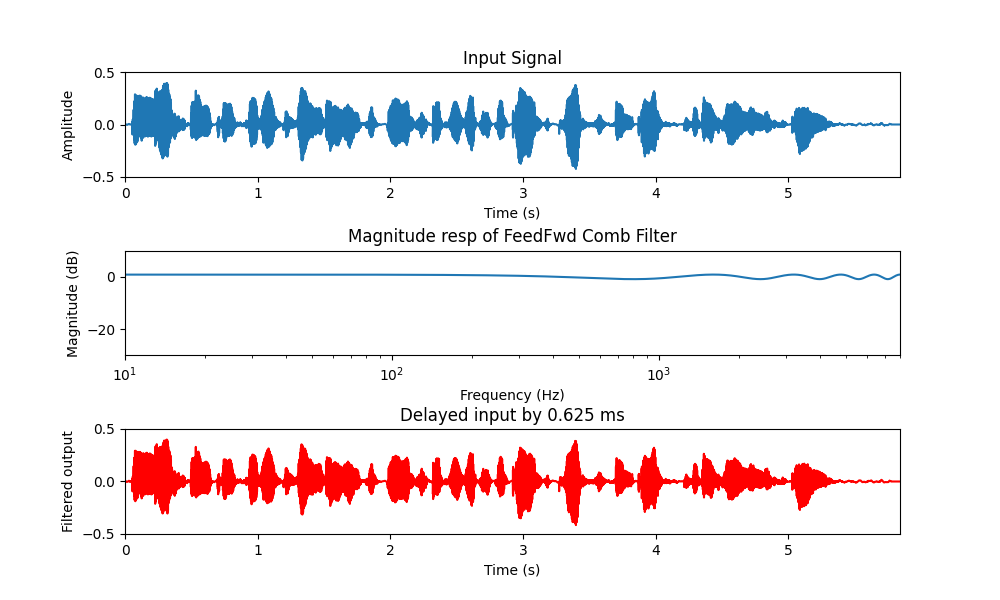

In [3]:
# Let's see what it sound's like!

# Convolution

[x, fs] = sf.read('speech.wav')
N_samples = len(x)           # total number of samples
n = np.arange(0,N_samples,1) # This sets up a vector of the sample indices
tt = n/fs                    # vector in time (seconds)

# Input impulse
x_imp = np.zeros(N_samples); 
x_imp[0] = 1 # This makes x an impulse


fig, axes = plt.subplots(3,1, figsize=(10, 6)) 
fig.subplots_adjust(hspace=0.7)
line_input = axes[0].plot(tt,x, label='input')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_ylim([-0.5, 0.5])
axes[0].set_xlim([0, tt[-1]])
axes[0].set_title('Input Signal')

print("Listen to the input:")
IPython.display.display(Audio(x.T, rate=fs,normalize=True))


line_mag, = axes[1].semilogx([],[])
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude (dB)')
axes[1].set_title('Magnitude resp of FeedFwd Comb Filter')
axes[1].set_xlim([10, fs//2])
axes[1].set_ylim([-30, 10])

line_output, = axes[2].plot([],[],'r', label='output')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Filtered output')
axes[2].set_ylim([-0.5, 0.5])
axes[2].set_xlim([0, tt[-1]])



def update(N = 10, g=0.1):
    
    # Create filter:
    b = np.zeros(N+1)
    b[0] = 1    # first value of b
    b[-1] = g   # make the last value g (the final coefficient)
    a = 1       # this is the denominator

    # Get freq. response of the loop filter    
    [w,h] = signal.freqz(b,a, fs=fs,worN=fs)
    h_abs_dB = 10*np.log10(np.abs(h)**2) # express magnitude in dB
    line_mag.set_data(w,h_abs_dB)
    
    # # Run the filter 
    y_filt = signal.lfilter(b,a,x)  
    line_output.set_data(tt, y_filt)
    axes[2].set_title('Delayed input by '+str((N/fs)*1000)+' ms')
    
    print("Listen to the output signal:")
    IPython.display.display(Audio(y_filt.T, rate=fs,normalize=True))
    IPython.display.clear_output(wait=True)


print('Move the slider to see how the hyperparameters affect performance ')
interact(update, N = (0,4000,1), g=(0,0.99,0.01));






### Feedback Comb Filter.

With the feedforward comb filter, we only consider a direct source and a single reflection. By alternatively doing the delay first and placing the gain in a feedback path, we can obtain a system that produces multiple reflections of progressively smaller amplitudes. This digital filter is referred to as a feedback comb filter and is depicted in Fig. 2.

The transfer function of the feedback comb filter is now given by:

\begin{equation}
H(z) = \frac{z^{-N}}{1 - g z^{-N}}
\end{equation}

As opposed to an FIR filter with the feedforward comb filter, we can observe that the feedback comb filter is an Infinite Impulse Response (IIR) filter as there are both numerator and denominator terms.

So for instance, if N = 2, we will have:
\begin{equation}
H(z) = \frac{z^{-2}}{1 - g z^{-2}}
\end{equation}

where upon comparison to the rational transfer function form, we can see that $b[0] = b[1] = 0$, $b[2]=1$, $a[1]=0, a[2] = -g$.


        
<br>
<br>

<div>
<center> <img src="img/feedback_comb.png" width="600"/> <center/>
    <p style="text-align:center">Fig. 2 - A feedback comb filter. </p>
</div>

<br>
<br>

Output()

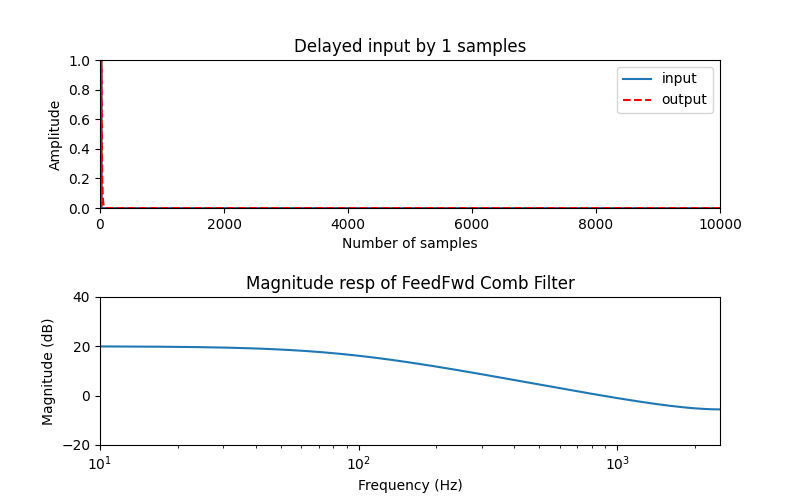

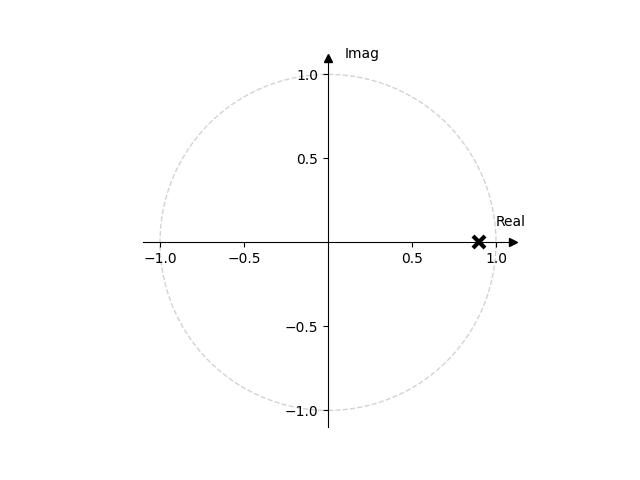

In [6]:
# Building a basic feedback comb filter line

# Initial parameters
fs = 5000                     # sampling frequency (Hz)
N_samples = 10000             # total number of samples
n = np.arange(0,N_samples,1)  # This sets up a vector of the sample indices
x = np.zeros(N_samples);      # initial input
x[20] = 1                    # This makes x an impulse


fig, axes = plt.subplots(2,1, figsize=(8, 5)) 
fig.subplots_adjust(hspace=0.6)
line_input = axes[0].plot(n,x, label='input')
line_output, = axes[0].plot([],[],'r--', label='output')
axes[0].set_xlabel('Number of samples')
axes[0].set_ylabel('Amplitude')
axes[0].set_ylim([0, 1])
axes[0].set_xlim([0, N_samples])
axes[0].legend()

line_mag, = axes[1].semilogx([],[])
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude (dB)')
axes[1].set_title('Magnitude resp of FeedFwd Comb Filter')
axes[1].set_xlim([10, fs//2])
axes[1].set_ylim([-20, 40])


# This is to set up the pole-zero plots
# Create the unit circle
fig, ax = plt.subplots() 
uc = patches.Circle((0,0), radius=1, fill=False, color='lightgray', ls='dashed')
ax.add_patch(uc)
 
# Plot the zeros and set marker properties    
t1, = ax.plot([], [], 'ko', ms=10)
plt.setp( t1, markersize=8.0, markeredgewidth=1.0,
          markeredgecolor='k', markerfacecolor='k')
# Plot the poles and set marker properties
t2, = ax.plot([], [], 'kx', ms=10)
plt.setp( t2, markersize=8.0, markeredgewidth=3.0,
          markeredgecolor='k', markerfacecolor='r')

ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)

# set the ticks
r = 1.1; 
ax.axis('scaled');
ticks_x = [-1, -0.5, 0.5, 1]; 
ticks_y = [-1, -0.5, 0.5, 1]; 
ax.set_xticks(ticks_x)
ax.set_yticks(ticks_y)
ax.text(1,0.1,'Real');
ax.text(0.1,1.1,'Imag');




def update(N = 10, g=0.1):
    
    # Create filter
    b = np.zeros(N+1)
    a = np.zeros(N+1)
    b[-1] = 1   # make the last value g (the final coefficient)
    a[0] = 1    # this is the denominator first coefficient
    a[-1] = -g    # this is the denominator last coefficient
    
    # Run the filter to get the impulse response
    y_filt = signal.lfilter(b,a,x)  
    line_output.set_data(n, y_filt)
    axes[0].set_title('Delayed input by '+str(N)+' samples')
    
    # Get freq. response of the loop filter    
    [w,h] = signal.freqz(b,a, fs=fs,worN=fs)
    h_abs_dB = 10*np.log10(np.abs(h)**2) # express magnitude in dB
    line_mag.set_data(w,h_abs_dB)
    
    # Get poles and zeros
    p = np.roots(a)
    z = np.roots(b)
    t2.set_data(p.real, p.imag)
#     print(g**(1/N))
#     print(np.abs(p))
    
    
    print('Listen to output')
    IPython.display.display(Audio(y_filt.T, rate=fs,normalize=True))
    
    return 

N_s    = IntSlider(min=1, max=400, step=1, value=0, description='N')
g_s    = FloatSlider(min=0, max=1.2, step=0.01, value=0.9, description='g')

out = interactive_output(update, {'N': N_s, 'g': g_s} ); 
layout = widgets.VBox([N_s, g_s])
IPython.display.display(layout,out)

# y_out = update(N=N_s.value, g = g_s.value)


Listen to the input:


Move the slider to see how the hyperparameters affect performance 


interactive(children=(IntSlider(value=10, description='N', max=4000), FloatSlider(value=0.1, description='g', …

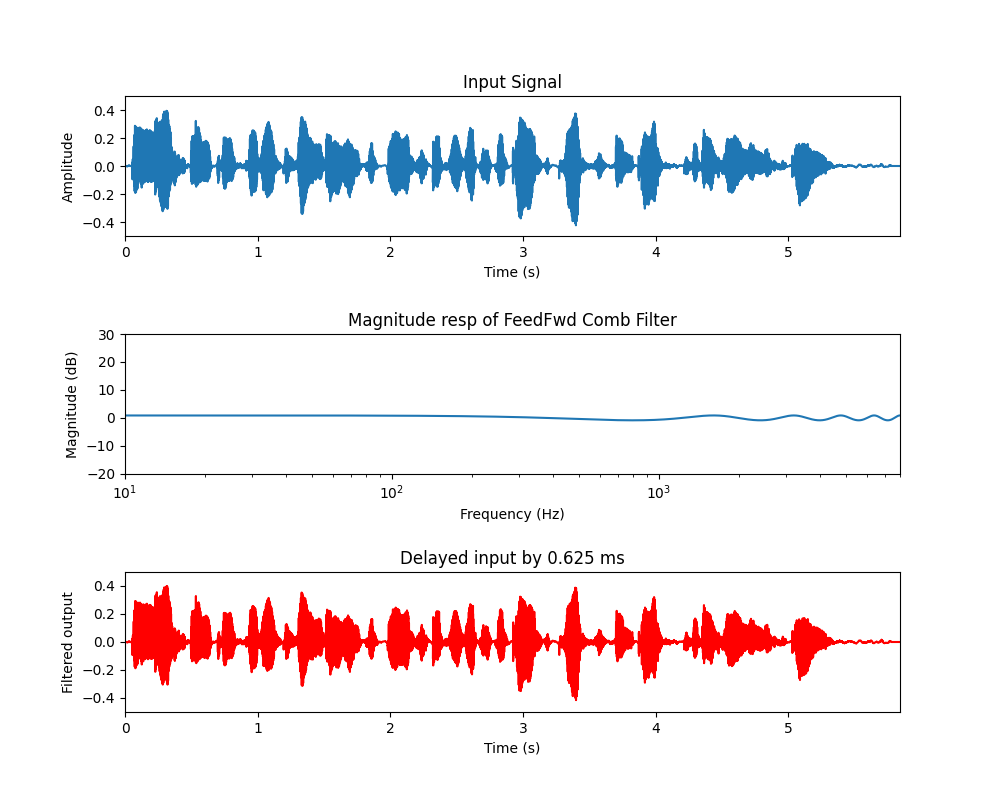

In [5]:
# Let's see what it sound's like!

# Convolution

[x, fs] = sf.read('speech.wav')
N_samples = len(x)           # total number of samples
n = np.arange(0,N_samples,1) # This sets up a vector of the sample indices
tt = n/fs                    # vector in time (seconds)

# Input impulse
x_imp = np.zeros(N_samples); 
x_imp[0] = 1 # This makes x an impulse


fig, axes = plt.subplots(3,1, figsize=(10, 8)) 
fig.subplots_adjust(hspace=0.7)
line_input = axes[0].plot(tt,x, label='input')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_ylim([-0.5, 0.5])
axes[0].set_xlim([0, tt[-1]])
axes[0].set_title('Input Signal')

print("Listen to the input:")
IPython.display.display(Audio(x.T, rate=fs,normalize=True))


line_mag, = axes[1].semilogx([],[])
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude (dB)')
axes[1].set_title('Magnitude resp of FeedFwd Comb Filter')
axes[1].set_xlim([10, fs//2])
axes[1].set_ylim([-20, 30])

line_output, = axes[2].plot([],[],'r', label='output')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Filtered output')
axes[2].set_ylim([-0.5, 0.5])
axes[2].set_xlim([0, tt[-1]])



def update(N = 10, g=0.1):
    
    # Create filter:
    b = np.zeros(N+1)
    a = np.zeros(N+1)
    b[-1] = 1   # make the last value g (the final coefficient)
    a[0] = 1    # this is the denominator first coefficient
    a[-1] = -g    # this is the denominator last coefficient

    # Get freq. response of the loop filter    
    [w,h] = signal.freqz(b,a, fs=fs,worN=fs)
    h_abs_dB = 10*np.log10(np.abs(h)**2) # express magnitude in dB
    line_mag.set_data(w,h_abs_dB)
    
    # # Run the filter 
    y_filt = signal.lfilter(b,a,x)  
    line_output.set_data(tt, y_filt)
    axes[2].set_title('Delayed input by '+str((N/fs)*1000)+' ms')
    
    print("Listen to the output signal:")
    IPython.display.display(Audio(y_filt.T, rate=fs,normalize=True))
    IPython.display.clear_output(wait=True)


print('Move the slider to see how the hyperparameters affect performance ')
interact(update, N = (0,4000,1), g=(0,0.99,0.01));




